In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data

import os
from os import listdir
import math
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [34]:
print(os.getcwd())
print(time.strftime('%Y_%m_%d'))


/home/nclab62159/workspace/school_work
2020_11_01


torch.Size([32, 6, 100])



<Figure size 432x288 with 0 Axes>

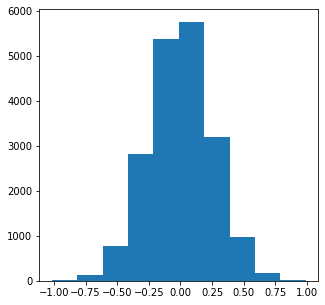

In [2]:
def Get_Normal_Dis(mean, std, size):
    '''
    if want out area is [-1, 1] :mean = 0, std =0.2~0.23
    '''
    return torch.from_numpy(np.random.normal(mean, std, size)).type(torch.FloatTensor)
    

data = Get_Normal_Dis(0, 0.25, [32, 6, 100])
print(data.size())
plt.clf()
plt.figure(figsize = (5, 5))
plt.hist(data.reshape(-1))
print()

<Figure size 432x288 with 0 Axes>

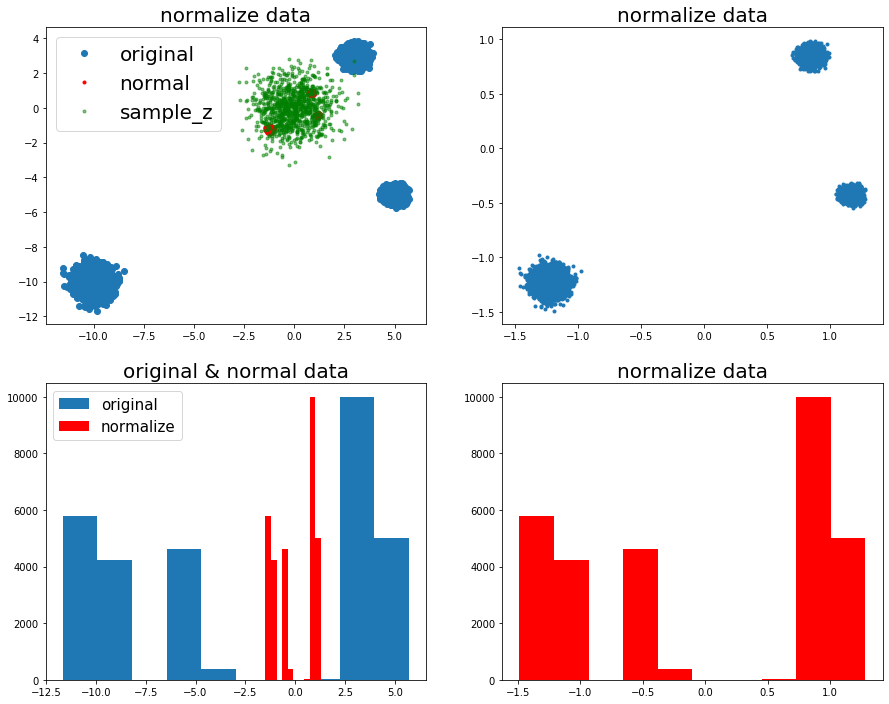

In [3]:
'''
對於GAN的思想 個人看法
透過GAN生成的方式 ,去擬和(fit)某個空間中的分佈
rand_noise input Generator , and then fit a distribution in space

假如沒有做正則化(標準化)
如圖所示 可以發現 sample的 z 沒有任何點 fit到data 
對於訓練上 比較有幫助(normalize)
'''
# 假設當前要擬和空間的分佈如下圖
dis_1 = Get_Normal_Dis(3, 0.25, [5000, 2])
label_1 = torch.zeros(5000, 1)
dis_2 = Get_Normal_Dis(-10, 0.4, [5000, 2])
label_2 = torch.ones(5000, 1)
dis_3 = Get_Normal_Dis(5, 0.2, [5000, 2])
label_3 = torch.ones(5000, 1)*2
dis_3[:, 1] = dis_3[:, 1]+ torch.ones(dis_3.size(0))*(-10)
# 
Train_Data = torch.cat([dis_1, dis_2, dis_3], dim = 0)
Train_Label = torch.cat([label_1, label_2, label_3] , dim = 0)
# 一般會使用normal distribution sample 出的data 作為 randn noise z 
latent_z = torch.randn(1000, 2)
# 一般 Generator 的最後一層 activation func. 為 tanh ,也就說 output_shape = (-1, 1)
# 透過 std 標準化
train_data_mean = torch.mean(Train_Data)
train_data_std = torch.std(Train_Data)
Train_Data_Normalize = (Train_Data - train_data_mean) / train_data_std

plt.clf()
fig, ax = plt.subplots(2, 2 ,figsize = (15, 12))
ax[0, 0].set_title('original & normal data', size = 20)
ax[0, 0].plot(Train_Data[:, 0].data.numpy(), Train_Data[:, 1].data.numpy(), 'o', label = 'original')
ax[0, 0].plot(Train_Data_Normalize[:, 0].data.numpy(), Train_Data_Normalize[:, 1].data.numpy(), '.', label= 'normal', color = 'r')
ax[0, 0].plot(latent_z[:, 0].data.numpy(), latent_z[:, 1].data.numpy(), '.', label= 'sample_z', alpha = 0.5, color ='g')
ax[0, 0].legend(fontsize = 20)
ax[0, 1].set_title('normalize data', size = 20)
ax[0, 1].plot(Train_Data_Normalize[:, 0].data.numpy(), Train_Data_Normalize[:, 1].data.numpy(), '.')

ax[1, 0].set_title('original & normal data', size = 20)
ax[1, 0].hist(Train_Data.reshape(-1).data.numpy(), label = 'original')
ax[1, 0].hist(Train_Data_Normalize.reshape(-1).data.numpy(), label = 'normalize', color = 'r')
ax[1, 0].legend(fontsize = 15)
ax[1, 1].set_title('normalize data', size = 20)
ax[1, 1].hist(Train_Data_Normalize.reshape(-1).data.numpy(), label = 'normalize', color = 'r')
print()

In [59]:
'''
original data
'''

class G_net_original(nn.Module):
    def __init__(self, n_dim = 128, z_dim = 100):
        super(G_net_original, self).__init__()
        
        self.fc1 = nn.Linear(z_dim, n_dim*8)
        self.fc2 = nn.Linear(n_dim*8, n_dim*2)
        self.fc3 = nn.Linear(n_dim*2, n_dim)
        self.fc_out = nn.Linear(n_dim, 2)
        
    def forward(self, noise_z):
        bs = noise_z.size(0)
        x = (self.fc1(noise_z))
        x = nn.ReLU()(self.fc2(x))
        x = torch.tanh(self.fc3 (x))
        out = self.fc_out(x)
        
        return out
    
class D_net_original(nn.Module):
    def __init__(self, n_dim = 128):
        super(D_net_original, self).__init__()
        
        self.fc1 = nn.Linear(2, n_dim*8)
        self.fc2 = nn.Linear(n_dim*8, n_dim*2)
        self.fc3 = nn.Linear(n_dim*2, 1)
        
    def forward(self, data):
        bs = data.size(0)
        x = (self.fc1(data))
        x = nn.ReLU()(self.fc2(x))
        out = torch.sigmoid(self.fc3 (x))
        
        return out
# ==
if __name__ == '__main__':
    bs = 32
    noise = torch.rand(bs, 100)
    data = torch.rand(bs, 2)
    
    model = G_net_original()
    out = model(noise)
    print(out.size())
    
    model = D_net_original()
    out = model(data)
    print(out.size())   

torch.Size([32, 2])
torch.Size([32, 1])


In [60]:
'''
normalize data
'''

class G_net_normalize(nn.Module):
    def __init__(self, n_dim = 128, z_dim = 100):
        super(G_net_normalize, self).__init__()
        
        self.fc1 = nn.Linear(z_dim, n_dim*8)
        self.fc2 = nn.Linear(n_dim*8, n_dim*2)
        self.fc3 = nn.Linear(n_dim*2, n_dim)
        self.fc_out = nn.Linear(n_dim, 2)
        
    def forward(self, noise_z):
        bs = noise_z.size(0)
        x = (self.fc1(noise_z))
        x = nn.ReLU()(self.fc2(x))
        x = torch.tanh(self.fc3 (x))
        out = self.fc_out(x)
        
        return out
    
class D_net_normalize(nn.Module):
    def __init__(self, n_dim = 128):
        super(D_net_normalize, self).__init__()
        
        self.fc1 = nn.Linear(2, n_dim*8)
        self.fc2 = nn.Linear(n_dim*8, n_dim*2)
        self.fc3 = nn.Linear(n_dim*2, 1)
    def forward(self, data):
        bs = data.size(0)
        x = (self.fc1(data))
        x = nn.ReLU()(self.fc2(x))
        out = torch.sigmoid(self.fc3 (x))
        
        return out
# ==
if __name__ == '__main__':
    bs = 32
    noise = torch.rand(bs, 100)
    data = torch.rand(bs, 2)
    
    model = G_net_normalize()
    out = model(noise)
    print(out.size())
    
    model = D_net_normalize()
    out = model(data)
    print(out.size())   
     

torch.Size([32, 2])
torch.Size([32, 1])


ori. data shape :  torch.Size([15000, 2])
nor. data shape :  torch.Size([15000, 2])
label shape : torch.Size([15000, 1])
save img file path : /home/nclab62159/workspace/school_work/start_GAN_img_folder/


NameError: name 'zz' is not defined

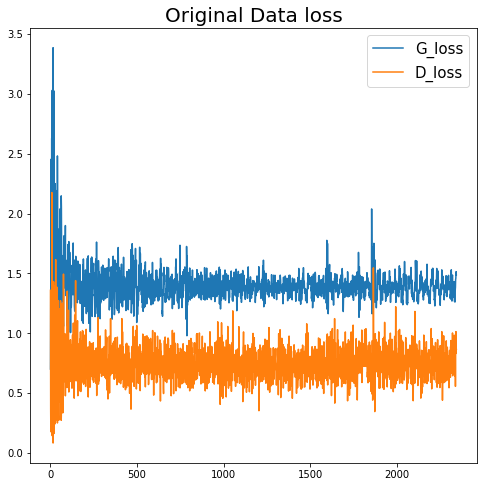

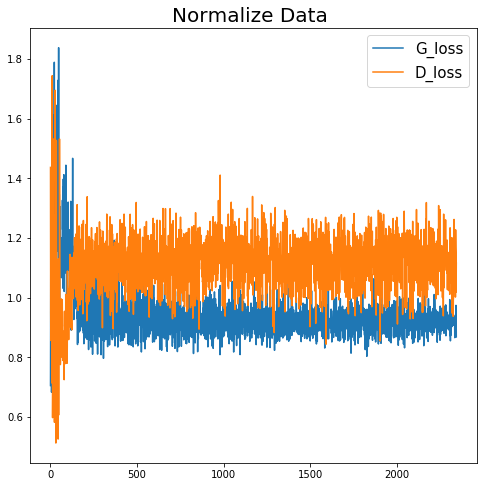

In [116]:
# 
EPOCH = 100
z_latent = 100
print('ori. data shape : ', Train_Data.size())
print('nor. data shape : ', Train_Data_Normalize.size())
print('label shape :', Train_Label.size())
file_path = os.getcwd()+'/start_GAN_img_folder/'
print('save img file path :', file_path)
if not os.path.isdir(file_path):
    os.mkdir(file_path)
# 
Dataset_ori = torch.utils.data.TensorDataset(Train_Data, Train_Label)
DataLoader_ori = torch.utils.data.DataLoader(dataset = Dataset_ori, batch_size = 32, shuffle = True)

Dataset_nor = torch.utils.data.TensorDataset(Train_Data_Normalize, Train_Label)
DataLoader_nor = torch.utils.data.DataLoader(dataset = Dataset_nor, batch_size = 32, shuffle = True)

# get model && optim
G_net_ori = G_net_original()
D_net_ori = D_net_original()
G_optim_ori = torch.optim.Adam(G_net_ori.parameters(), lr = 0.0001)
D_optim_ori = torch.optim.Adam(D_net_ori.parameters(), lr = 0.0001)

G_net_nor = G_net_normalize()
D_net_nor = D_net_normalize()
G_optim_nor = torch.optim.Adam(G_net_nor.parameters(), lr = 0.0001)
D_optim_nor = torch.optim.Adam(D_net_nor.parameters(), lr = 0.0001)

bce_loss = nn.BCELoss()

test_z = torch.randn(10000, z_latent)
if torch.cuda.is_available():
    G_net_ori.cuda()
    D_net_ori.cuda()
    
    G_net_nor.cuda()
    D_net_nor.cuda()
    
    bce_loss.cuda()
    
    test_z = test_z.cuda()
# ============
# training with Original Dataset
# ============
G_loss_log_ori , D_loss_log_ori = [], []
log_index = 0
for epoch in range(EPOCH):
    for n, (Data, Label) in enumerate(DataLoader_ori):
        real_valid = torch.ones(Data.size(0), 1)
        fake_valid = torch.zeros(Data.size(0), 1)
        noise_z = torch.randn(Data.size(0), z_latent)
        
        if torch.cuda.is_available():
            real_valid = real_valid.cuda()
            fake_valid = fake_valid.cuda()
            noise_z = noise_z.cuda()
            Data = Data.cuda()
            Label = Label.cuda()
        # train G_net
        G_optim_ori.zero_grad()
        Syn_data = G_net_ori(noise_z)
        g_loss = bce_loss( D_net_ori(Syn_data) , real_valid)
        g_loss.backward()
        G_optim_ori.step()
        
        # train D_net
        D_optim_ori.zero_grad()
        d_real_loss = bce_loss( D_net_ori(Data) , real_valid)
        d_fake_loss = bce_loss( D_net_ori(Syn_data.detach()), fake_valid)
        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        D_optim_ori.step()
        if log_index % 20 == 0:
            G_loss_log_ori.append(g_loss)
            D_loss_log_ori.append(d_loss)
        log_index +=1
    with torch.no_grad():
        plt.clf()
        plt.close()

        Syn_out = G_net_ori(test_z)
        if Syn_out.is_cuda:
            Syn_out = Syn_out.data.cpu().numpy()
        else:
            Syn_out = Syn_out.data.numpy()
        fig = plt.figure(figsize = (5, 5))
        plt.title('Original EPOCH '+str(epoch+1))
        plt.plot(Train_Data[:, 0].data.numpy(), Train_Data[:, 1].data.numpy(),'o')
        plt.plot(Syn_out[:, 0], Syn_out[:, 1],'.', color = 'r')
        save_file = file_path + 'train_Ori_data/' 
        if not os.path.isdir(save_file):
            os.mkdir(save_file)
        plt.savefig(save_file+time.strftime('%Y_%m_%d')+'_epoch_'+str(epoch+1)+'.png')
        
# plot loss log


# ============
# training with Normalize Dataset
# ============
G_loss_log_nor , D_loss_log_nor = [], []
log_index = 0
for epoch in range(EPOCH):
    for n, (Data, Label) in enumerate(DataLoader_nor):
        real_valid = torch.ones(Data.size(0), 1)
        fake_valid = torch.zeros(Data.size(0), 1)
        noise_z = torch.randn(Data.size(0), z_latent)
        
        if torch.cuda.is_available():
            real_valid = real_valid.cuda()
            fake_valid = fake_valid.cuda()
            noise_z = noise_z.cuda()
            Data = Data.cuda()
            Label = Label.cuda()
         # train G_net
        G_optim_nor.zero_grad()
        Syn_data = G_net_nor(noise_z)
        g_loss = bce_loss( D_net_nor(Syn_data) , real_valid)
        g_loss.backward()
        G_optim_nor.step()
        
        # train D_net
        D_optim_nor.zero_grad()
        d_real_loss = bce_loss( D_net_nor(Data) , real_valid)
        d_fake_loss = bce_loss( D_net_nor(Syn_data.detach()), fake_valid)
        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        D_optim_nor.step()
        if log_index % 20 == 0:
            G_loss_log_nor.append(g_loss)
            D_loss_log_nor.append(d_loss)
        log_index +=1
    with torch.no_grad():
        plt.clf()
        plt.close()

        Syn_out = G_net_nor(test_z)
        if Syn_out.is_cuda:
            Syn_out = Syn_out.data.cpu().numpy()
        else:
            Syn_out = Syn_out.data.numpy()
        fig = plt.figure(figsize = (5, 5))
        plt.title('Normalize EPOCH '+str(epoch+1))
        plt.plot(Train_Data_Normalize[:, 0].data.numpy(), Train_Data_Normalize[:, 1].data.numpy(),'o')
        plt.plot(Syn_out[:, 0], Syn_out[:, 1],'.', color = 'r')
        save_file = file_path + 'train_Normal_data/' 
        if not os.path.isdir(save_file):
            os.mkdir(save_file)
        plt.savefig(save_file+time.strftime('%Y_%m_%d')+'_epoch_'+str(epoch+1)+'.png')
        
# plot loss log

# original data
plt.clf()
plt.close('all')

fig = plt.figure(figsize=(8, 8))
plt.title('Original Data loss', size = 20)
plt.plot(np.arange(len(G_loss_log_ori)), G_loss_log_ori, label = 'G_loss')
plt.plot(np.arange(len(D_loss_log_ori)), D_loss_log_ori, label = 'D_loss')
plt.legend(fontsize = 15)

# normalize data
fig = plt.figure(figsize=(8, 8))
plt.title('Normalize Data ', size = 20)
plt.plot(np.arange(len(G_loss_log_nor)), G_loss_log_nor, label = 'G_loss')
plt.plot(np.arange(len(D_loss_log_nor)), D_loss_log_nor, label = 'D_loss')
plt.legend(fontsize = 15)




print(zz)

torch.Size([15000, 2])
(10000, 100)
torch.Size([10000, 2])
torch.Size([10000, 2])



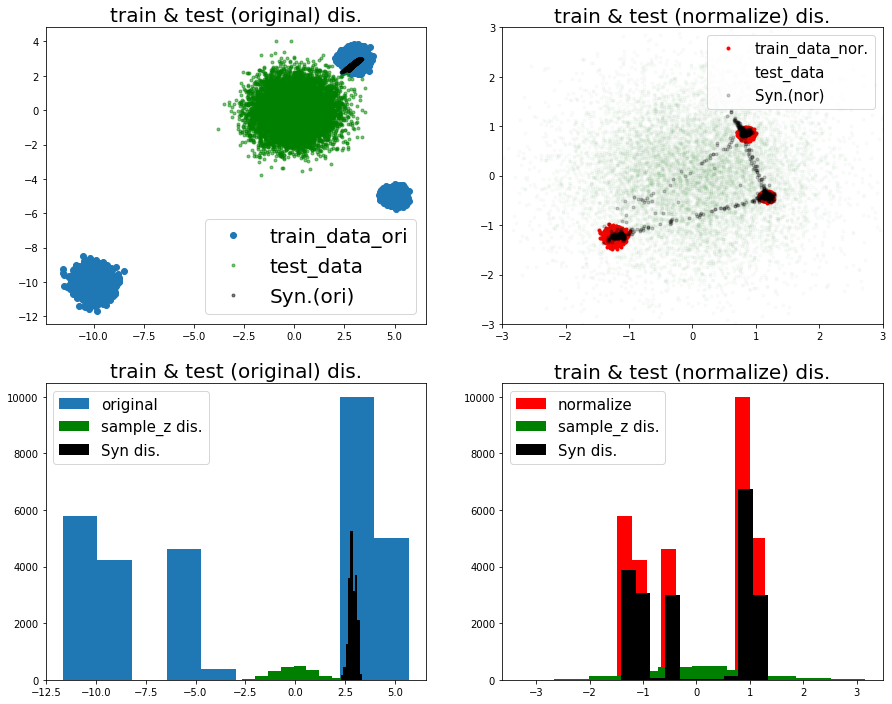

In [115]:
'''
小結(sucessful sample)
由於使用的normalize 方法是 mean_std
所以可以看出分佈不會在(-1, 1)之間
所以在g的最後一層才在接了一層fc
可以自行嘗試 其他normalize的方法

數量表示部份 input_noise_z  = [10000, 100]
           output_syn_data = [10000, 2]
'''

original_Syn_out = G_net_ori(test_z)
normalize_Syn_out = G_net_nor(test_z)
print(Train_Data.size())
print(test_data.shape)
print(original_Syn_out.size())
print(normalize_Syn_out.size())

test_data = test_z
if original_Syn_out.is_cuda:
    original_Syn_out = original_Syn_out.data.cpu().numpy()
    normalize_Syn_out = normalize_Syn_out.data.cpu().numpy()
    test_data = test_data.data.cpu().numpy()
else:
    original_Syn_out = original_Syn_out.data.numpy()
    normalize_Syn_out = normalize_Syn_out.data.numpy()
    test_data = test_data.data.numpy()

#==== surcessful distribution compare 
plt.clf() 
plt.close()
fig, ax = plt.subplots(2, 2 ,figsize = (15, 12))
ax[0, 0].set_title('train & test (original) dis.', size = 20)
ax[0, 0].plot(Train_Data[:, 0].data.numpy(), Train_Data[:, 1].data.numpy(), 'o', label = 'train_data_ori')
ax[0, 0].plot(test_data[:, 0], test_data[:, 1], '.', label= 'test_data', alpha = 0.5, color ='g')
ax[0, 0].plot(original_Syn_out[:, 0], original_Syn_out[:, 1], '.', label= 'Syn.(ori)', alpha = 0.5, color ='#000000')
ax[0, 0].legend(fontsize = 20)

ax[0, 1].set_title('train & test (normalize) dis.', size = 20)
ax[0, 1].plot(Train_Data_Normalize[:, 0].data.numpy(), Train_Data_Normalize[:, 1].data.numpy(), '.', label='train_data_nor.', color = 'r')
ax[0, 1].plot(test_data[:, 0], test_data[:, 1], '.', label= 'test_data', alpha = 0.02, color ='g')
ax[0, 1].plot(normalize_Syn_out[:, 0], normalize_Syn_out[:, 1], '.', color = '#000000', label='Syn.(nor)', alpha = 0.2)
ax[0, 1].set_xlim(-3,3)
ax[0, 1].set_ylim(-3,3)
ax[0, 1].legend(fontsize = 15)

ax[1, 0].set_title('train & test (original) dis.', size = 20)
ax[1, 0].hist(Train_Data.reshape(-1).data.numpy(), label = 'original')
ax[1, 0].hist(latent_z.reshape(-1).data.numpy(), label = 'sample_z dis.', color = 'g')
ax[1, 0].hist(original_Syn_out.reshape(-1), label = 'Syn dis.', color = '#000000')
ax[1, 0].legend(fontsize = 15)

ax[1, 1].set_title('train & test (normalize) dis.', size = 20)
ax[1, 1].hist(Train_Data_Normalize.reshape(-1).data.numpy(), label = 'normalize', color = 'r')
ax[1, 1].hist(latent_z.reshape(-1).data.numpy(), label = 'sample_z dis.', color = 'g')
ax[1, 1].hist(normalize_Syn_out.reshape(-1), label = 'Syn dis.', color = '#000000')
ax[1, 1].legend(fontsize = 15)



plt.savefig(file_path+time.strftime('%Y_%m_%d_Epoch_num_')+str(EPOCH)+'_sample dis.png')
print()

torch.Size([15000, 2])
(10000, 100)
torch.Size([10000, 2])
torch.Size([10000, 2])



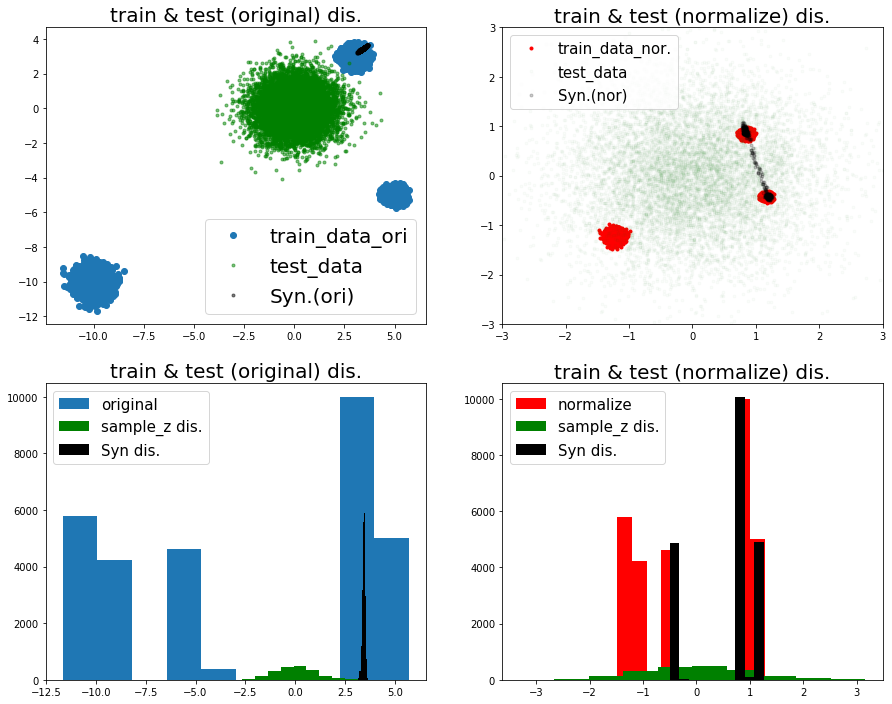

In [120]:
'''
sample 2
由分佈圖來看
已完全集中在某一數值
所以在最下方的圖的分佈會比較集中在某一數值
對於較遠的分佈就比較不太會去擬和
sample code 的數量 30000：20000(reshape 過後)
'''

original_Syn_out = G_net_ori(test_z)
normalize_Syn_out = G_net_nor(test_z)
print(Train_Data.size())
print(test_data.shape)
print(original_Syn_out.size())
print(normalize_Syn_out.size())

test_data = test_z
if original_Syn_out.is_cuda:
    original_Syn_out = original_Syn_out.data.cpu().numpy()
    normalize_Syn_out = normalize_Syn_out.data.cpu().numpy()
    test_data = test_data.data.cpu().numpy()
else:
    original_Syn_out = original_Syn_out.data.numpy()
    normalize_Syn_out = normalize_Syn_out.data.numpy()
    test_data = test_data.data.numpy()

#==== surcessful distribution compare 
plt.clf() 
plt.close()
fig, ax = plt.subplots(2, 2 ,figsize = (15, 12))
ax[0, 0].set_title('train & test (original) dis.', size = 20)
ax[0, 0].plot(Train_Data[:, 0].data.numpy(), Train_Data[:, 1].data.numpy(), 'o', label = 'train_data_ori')
ax[0, 0].plot(test_data[:, 0], test_data[:, 1], '.', label= 'test_data', alpha = 0.5, color ='g')
ax[0, 0].plot(original_Syn_out[:, 0], original_Syn_out[:, 1], '.', label= 'Syn.(ori)', alpha = 0.5, color ='#000000')
ax[0, 0].legend(fontsize = 20)

ax[0, 1].set_title('train & test (normalize) dis.', size = 20)
ax[0, 1].plot(Train_Data_Normalize[:, 0].data.numpy(), Train_Data_Normalize[:, 1].data.numpy(), '.', label='train_data_nor.', color = 'r')
ax[0, 1].plot(test_data[:, 0], test_data[:, 1], '.', label= 'test_data', alpha = 0.02, color ='g')
ax[0, 1].plot(normalize_Syn_out[:, 0], normalize_Syn_out[:, 1], '.', color = '#000000', label='Syn.(nor)', alpha = 0.2)
ax[0, 1].set_xlim(-3,3)
ax[0, 1].set_ylim(-3,3)
ax[0, 1].legend(fontsize = 15)

ax[1, 0].set_title('train & test (original) dis.', size = 20)
ax[1, 0].hist(Train_Data.reshape(-1).data.numpy(), label = 'original')
ax[1, 0].hist(latent_z.reshape(-1).data.numpy(), label = 'sample_z dis.', color = 'g')
ax[1, 0].hist(original_Syn_out.reshape(-1), label = 'Syn dis.', color = '#000000')
ax[1, 0].legend(fontsize = 15)

ax[1, 1].set_title('train & test (normalize) dis.', size = 20)
ax[1, 1].hist(Train_Data_Normalize.reshape(-1).data.numpy(), label = 'normalize', color = 'r')
ax[1, 1].hist(latent_z.reshape(-1).data.numpy(), label = 'sample_z dis.', color = 'g')
ax[1, 1].hist(normalize_Syn_out.reshape(-1), label = 'Syn dis.', color = '#000000')
ax[1, 1].legend(fontsize = 15)



# plt.savefig(file_path+time.strftime('%Y_%m_%d_Epoch_num_')+str(EPOCH)+'_sample dis.png')
print()